$\newcommand{\xv}{\mathbf{x}}
 \newcommand{\wv}{\mathbf{w}}
 \newcommand{\yv}{\mathbf{y}}
 \newcommand{\zv}{\mathbf{z}}
 \newcommand{\uv}{\mathbf{u}}
 \newcommand{\vv}{\mathbf{v}}
 \newcommand{\Chi}{\mathcal{X}}
 \newcommand{\R}{\rm I\!R}
 \newcommand{\sign}{\text{sign}}
 \newcommand{\Tm}{\mathbf{T}}
 \newcommand{\Xm}{\mathbf{X}}
 \newcommand{\Zm}{\mathbf{Z}}
 \newcommand{\I}{\mathbf{I}}
 \newcommand{\Um}{\mathbf{U}}
 \newcommand{\Vm}{\mathbf{V}} 
 \newcommand{\muv}{\boldsymbol\mu}
 \newcommand{\Sigmav}{\boldsymbol\Sigma}
 \newcommand{\Lambdav}{\boldsymbol\Lambda}
$

In this note, we discuss the two subtopics of unsupervised learing, clustering and dimensionality reduction.


# Clustering


When there is no information available for classification target, often we still want to find different groups of data. We call these as *clusters*, and we call this approach as *clustering*. Let us talk about two clustering techniques, k-means and Gaussian mixture models. 


In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## K-means

First and easy clustering approach is K-means algorithm, which is non-probabilistic. 
Without knowing about actual groups, we want to find K partitions of N observations in D dimensions. 
That is, the observation data $\Xm = {\xv_1, \cdots, \xv_N}$ and $\xv_i \in \R^D$.
When we devide data into K clusters, an intuitive way is to find groups whose inter-point distances inside a cluster are smaller than the out-side-cluter-point distances.  

We can formulate this by selecting a center of each cluster, named $\muv_k$:

$$
E = \sum_{i=1}^{N} \sum_{k=1}^{K} \delta_{ik} \Vert \xv_i - \muv_k \Vert^2.
$$

where $\delta_{ik} \in {0, 1}$ is a binary indicator variable that has 1 if $\xv_i$ is assigned to cluster $k$, otherwise 0. 

Thus, our goal is finding the $\delta_ik$ and $\muv_k$ that minimizes the $E$. 

For this goal, 

1. we first choose an initial $\muv_k$ randomly,

2. minimize $E$ w.r.t. the $\delta_{ik}$.

3. Now, fixing the $\delta_{ik}$, update $\muv_k$ that minimizes $E$. 

4. Repeating 2 and 3, we obtain the $K$ clusters after convergence. 

In [34]:
# K-means: Sketch. 
import numpy as np
from copy import deepcopy as copy
def kmeans(X, K=2, maxiter=100):
    N = X.shape[0]
    # select initial centers
    cidx = np.random.choice(N, K, replace=False)
    centers = X[cidx, :]
    old_centers=copy(centers)
    E=[]
    # repeat until convergence or up to maxiter
    for step in range(maxiter):
        #### TODO: finish this for-loop for k-means!
        # Assignment: find clusters that minimizes E with current centers
        distance=np.sum((X - centers[:,np.newaxis,:])**2, axis=2)
        # compute E and check convergence
        classes=np.argmin(distance, axis=0)
        E.append(np.sum([np.sum(X[np.where(classes == i)[0],:]) for i in np.unique(classes)]))
        # Update: update cluster centers
        for i in np.sort(np.unique(classes)):
            centers[i,:]=np.mean(X[np.where(classes == i)[0],:], axis=0)
        if E[step] <= 0.1 or np.mean((old_centers-centers)**2) < 0.01:
            return centers, classes, E
        old_centers=copy(centers)
    return centers, classes, E

## Hint and Sample Data Practice

Here follows some hints to fill in the blanks. 

In [41]:
X = np.random.rand(100,2)

In [42]:
kmeans(X)

(array([[ 0.50366943,  0.68195014],
        [ 0.44117236,  0.2121676 ]]),
 array([0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        0, 1, 1, 1, 1, 0, 1, 0]),
 [96.206213519674264, 96.20621351967425])

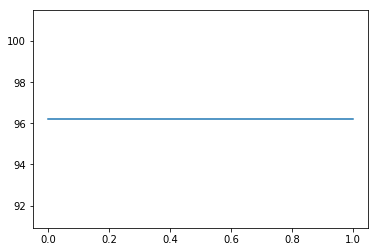

In [43]:
mus, classes, errs = kmeans(X)

plt.plot(errs)

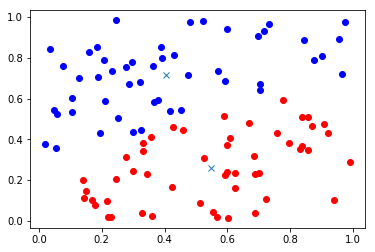

In [44]:
plt.plot(X[classes==0, 0], X[classes==0, 1], 'or')
plt.plot(X[classes==1, 0], X[classes==1, 1], 'ob')
plt.plot(mus[:, 0], mus[:, 1], 'x')

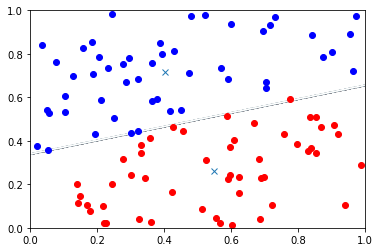

In [45]:
xs, ys = np.meshgrid(np.linspace(0, 1, 500), np.linspace(0, 1, 500))

Xb = np.vstack((xs.flat, ys.flat)).T

# find classes from the mus
edists = np.sum((Xb - mus[:,np.newaxis,:])**2, axis=2)
cs = np.argmin(edists, axis=0)

# plot the boundary
plt.clf()
plt.contour(xs, ys, cs.reshape(xs.shape), cmap=plt.cm.bone)
plt.plot(X[classes==0, 0], X[classes==0, 1], 'or')
plt.plot(X[classes==1, 0], X[classes==1, 1], 'ob')
plt.plot(mus[:, 0], mus[:, 1], 'x')



# Gaussian Mixture

Previously we learned K-means clustering algorithm with linear border for each classes.  
We observed that near the border, there are vague assignment. 
How confident are you on the assignments, especially near the border in K-means? 

With probabilistic model, we can softly assign clusters with a certain probability. 
For this, we can assume each cluster is Gaussian distribution:

$$p(\xv_k) \sim N(\xv_k \mid \muv_k, \Sigmav_k).$$

For the entire data $\xv \in \{\xv_1, \cdots, \xv_K \}$, 
the Gaussian mixture distribution can be written as 


$$p(\xv) = \sum_{k=1}^K \pi_k N(\xv \mid \muv_k, \Sigmav_k).$$


Here, we assume the latent indicator variable $\zv$, which satisfys $z_k \in \{0, 1\}$ and $\sum_k z_k = 1$. 
In the above Gaussian mixture model, $\pi_k$ is called as a *mixing coefficient*, which is the marginal distribution over $\zv$, 

$$
p(z_k = 1) = \pi_k,
$$

such that 


$$
0 \le \pi_k \le 1, 
$$

and 

$$
\sum_{k=1}^{K} \pi_k = 1.
$$

Since $\zv$ is a indicator variable, we can write

$$
p(\zv) = \prod_{k=1}^K \pi_k^{z_k}.
$$

From our first assumption of Gaussian for each class, 

$$
p(\xv_k) = p(\xv \mid z_k = 1) = N(\xv \mid \muv_k, \Sigmav_k).
$$

Rewriting this with a vector notation,

$$
p(\xv \mid \zv) = \prod_{k=1}^K N(\xv \mid \muv_k, \Sigmav_k)^{z_k}.
$$

Marginalizing the joint distribution $p(\xv, \zv)$ over $\zv$, 

$$
p(\xv) = \sum_{\zv} p(\zv) p(\xv \mid \zv) = \sum_{k=1}^K \pi_k N(\xv \mid \muv_k, \Sigmav_k). 
$$


Remember that in logistic regression and discriminant analysis models, we are interested in the posterior probability
$p(T=k \mid \xv)$. 
Similarly, we are interested in the probability of the classification from the observation $\xv$, thus,

$$
\begin{align*}
p(z_k = 1 \mid \xv) &= \frac{p(\xv \mid z_k = 1) p(z_k= 1)}{p(\xv)} \\
 \\
                    &= \frac{ \pi_kN(\xv \mid \muv_k, \Sigmav_k)}{\sum_{l=1}^K \pi_l N(\xv \mid \muv_l, \Sigmav_l)}.
\end{align*}
$$

For concise notation, let us define $\kappa(z_k) \equiv p(z_k = 1 \mid \xv)$. 


## Likelihood

Now, consider the batch data input $\Xm$ with $N$ data samples and $D$ dimensional input for each. 
Here, the latent variables are now in matrix $\Zm$ for $N$ samples and $K$ classes. 

From the marginal distribution and the assumption of i.i.d, we can write the likelihood function:

$$
\begin{align*}
p(\Xm \mid \pi, \muv, \Sigmav) &= \prod_{n=1}^N p(\xv_n, \zv_n) \\
                               &= \prod_{n=1}^N p(\xv_n \mid \zv_n) p(\zv_n) \\
                               &= \prod_{n=1}^N \prod_{k=1}^{K} \Big[ \pi_k N(\xv_n \mid \muv_k, \Sigmav_k)\Big]^{z_k} .
\end{align*}
$$

Applying the logarihtm, the log-likelihood is 

$$
LL = \ln p(\Xm \mid \pi, \muv, \Sigmav) = \sum_{n=1}^N \ln \Big[ \sum_{k=1}^K\pi_k N(\xv_n \mid \muv_k, \Sigmav_k)  \Big]. 
$$


## The parameters: $\muv, \Sigma, \pi$

Now, let us find the maximum of the log-likelihood w.r.t $\muv_k$, $\Sigmav_k$, and $\pi_k$. 
Before this, let's review the derivation of multivariate Gaussian distribution.

### Derivation of Gaussian

#### - w.r.t. $\muv$,
$$
\begin{align*}
\frac{d}{d\muv} N(\xv; \muv, \Sigmav) &= \frac{d}{d\muv} \Bigg[  \frac{1}{ (2\pi)^{\frac{d}{2}} \vert \Sigmav \vert^{\frac{1}{2}}} e^{ - \frac{1}{2} (\xv - \muv)^\top \Sigmav^{-1} (\xv - \muv) } \Bigg] \\
\\
  &= \Bigg[  \frac{1}{ (2\pi)^{\frac{d}{2}} \vert \Sigmav \vert^{\frac{1}{2}}} e^{ - \frac{1}{2} (\xv - \muv)^\top \Sigmav^{-1} (\xv - \muv) } \Bigg] \frac{d}{d\muv}\Bigg( - \frac{1}{2} (\xv - \muv)^\top \Sigmav^{-1} (\xv - \muv) \Bigg) \\
  \\
  &= \Bigg[  \frac{1}{ (2\pi)^{\frac{d}{2}} \vert \Sigmav \vert^{\frac{1}{2}}} e^{ - \frac{1}{2} (\xv - \muv)^\top \Sigmav^{-1} (\xv - \muv) } \Bigg] \frac{d}{d\muv}\Bigg( - \frac{1}{2} [ \xv^\top \Sigmav^{-1} \xv - 2 \muv^\top \Sigmav^{-1} \xv + \muv^\top \Sigmav^{-1} \muv ] \Bigg) \\
  \\
  &= \Bigg[  \frac{1}{ (2\pi)^{\frac{d}{2}} \vert \Sigmav \vert^{\frac{1}{2}}} e^{ - \frac{1}{2} (\xv - \muv)^\top \Sigmav^{-1} (\xv - \muv) } \Bigg] \Bigg( \Sigmav^{-1} \xv - \Sigmav^{-1} \muv \Bigg) \\
  \\
  &= N(\xv; \muv, \Sigmav) \Sigmav^{-1} (\xv - \muv) 
\end{align*}
$$

#### -  w.r.t. $\Sigmav$, 
$$
\begin{align*}
\frac{d}{d\Sigmav} N(\xv; \muv, \Sigmav) &= \frac{d}{d\Sigmav} \Bigg[  (2\pi)^{-\frac{d}{2}} \vert \Sigmav \vert^{-\frac{1}{2}} e^{ - \frac{1}{2} (\xv - \muv)^\top \Sigmav^{-1} (\xv - \muv) } \Bigg] \\
\\
&= (2\pi)^{-\frac{d}{2}} \frac{d}{d\Sigmav} \Bigg[  \vert \Sigmav \vert^{-\frac{1}{2}} e^{ - \frac{1}{2} (\xv - \muv)^\top \Sigmav^{-1} (\xv - \muv) } \Bigg] \\
\\
&= (2\pi)^{-\frac{d}{2}} \Bigg[  \frac{d \vert \Sigmav \vert^{-\frac{1}{2}}}{d\Sigmav} e^{ - \frac{1}{2} (\xv - \muv)^\top \Sigmav^{-1} (\xv - \muv) } + \vert \Sigmav \vert^{-\frac{1}{2}} \frac{d  e^{ - \frac{1}{2} (\xv - \muv)^\top \Sigmav^{-1} (\xv - \muv) } }{d\Sigmav}\Bigg] \\
\\
&= (2\pi)^{-\frac{d}{2}} \Bigg[ -\frac{1}{2} \vert \Sigmav \vert^{-\frac{3}{2}} \frac{d \vert \Sigmav \vert }{d\Sigmav} e^{ - \frac{1}{2} (\xv - \muv)^\top \Sigmav^{-1} (\xv - \muv) } + \vert \Sigmav \vert^{-\frac{1}{2}} e^{ - \frac{1}{2} (\xv - \muv)^\top \Sigmav^{-1} (\xv - \muv) } \frac{d \big( - \frac{1}{2} (\xv - \muv)^\top \Sigmav^{-1} (\xv - \muv) \big)}{d\Sigmav} \Bigg] \\
\\
&= (2\pi)^{-\frac{d}{2}} \Bigg[  -\frac{1}{2} \vert \Sigmav \vert^{-\frac{3}{2}} \vert \Sigmav \vert \Sigmav^{-1} e^{ - \frac{1}{2} (\xv - \muv)^\top \Sigmav^{-1} (\xv - \muv) } -\frac{1}{2} 
\vert \Sigmav \vert^{-\frac{1}{2}} e^{ - \frac{1}{2} (\xv - \muv)^\top \Sigmav^{-1} (\xv - \muv) } (- \Sigmav^{-1} (\xv - \muv) (\xv - \muv)^\top  \Sigmav^{-1} ) \Bigg] \\
\\
&= -\frac{1}{2} (2\pi)^{-\frac{d}{2}} \Bigg[ \vert \Sigmav \vert^{-\frac{1}{2}} \Sigmav^{-1} e^{ - \frac{1}{2} (\xv - \muv)^\top \Sigmav^{-1} (\xv - \muv) } + \vert \Sigmav \vert^{\frac{1}{2}} e^{ - \frac{1}{2} (\xv - \muv)^\top \Sigmav^{-1} (\xv - \muv) } \Sigmav^{-1} (\xv - \muv) (\xv - \muv)^\top  \Sigmav^{-1} \Bigg] \\
\\
&= -\frac{1}{2} (2\pi)^{-\frac{d}{2}} \vert \Sigmav \vert^{-\frac{1}{2}}  e^{ - \frac{1}{2} (\xv - \muv)^\top \Sigmav^{-1} (\xv - \muv) } \Sigmav^{-1} \Bigg[ \I - (\xv - \muv) (\xv - \muv)^\top  \Sigmav^{-1} \Bigg] \\
\\
&= -\frac{1}{2} N(\xv; \muv, \Sigmav) \Sigmav^{-1} \Bigg[ \I - (\xv - \muv) (\xv - \muv)^\top  \Sigmav^{-1} \Bigg]
\end{align*}
$$

<hr/>

Now, back to the derivation of the log-likelihood: 

$$
\begin{align*}
\frac{\partial LL}{\partial \muv_k} &= \sum_{n=1}^N \frac{1}{\sum_{l=1}^K\pi_l N(\xv_n \mid \muv_l, \Sigmav_l)}  \nabla_{\muv_k}  \Big[ \sum_{k=1}^K\pi_k N(\xv_n \mid \muv_k, \Sigmav_k)  \Big] \\
\\
                    &=  \sum_{n=1}^N \frac{1}{\sum_{l=1}^K\pi_l N(\xv_n \mid \muv_l, \Sigmav_l)} \nabla_{\muv_k}  \pi_k N(\xv_n \mid \muv_k, \Sigmav_k) \\
                    \\
                     &=  \sum_{n=1}^N \frac{1}{\sum_{l=1}^K\pi_l N(\xv_n \mid \muv_l, \Sigmav_l)} \pi_kN(\xv_n; \muv_k, \Sigmav_k) \Sigmav_k^{-1} (\xv_n - \muv_k)
                     \\
                     &=  \sum_{n=1}^N \frac{\pi_k N(\xv_n; \muv_k, \Sigmav_k)}{\sum_{l=1}^K\pi_l N(\xv_n \mid \muv_l, \Sigmav_l)}  \Sigmav_k^{-1} (\xv_n - \muv_k) \\
                     \\
                     &= \sum_{n=1}^N \kappa(z_k) \Sigmav_k^{-1} (\xv_n - \muv_k)
\end{align*}                 
$$

Setting this to zero, 

$$
\sum_{n=1}^N \kappa(z_k) \Sigmav_k^{-1} (\xv_n - \muv_k) = 0 \\ 
\sum_{n=1}^N \kappa(z_k) (\xv_n - \muv_k) = 0 \\
\sum_{n=1}^N \kappa(z_k) \xv_n =  \sum_{n=1}^N \kappa(z_k) \muv_k \\
\sum_{n=1}^N \kappa(z_k) \xv_n =  N_k \muv_k \\
\\
\muv_k = \frac{1}{N_k} \sum_{n=1}^N \kappa(z_k) \xv_n,
$$

where the number of samples for class $k$, $N_k = \sum_{n=1}^{N} \kappa(z_k)$.

Now, w.r.t $\Sigmav_k$, 

$$
\begin{align*}
\frac{\partial LL}{\partial \Sigmav_k} &= \sum_{n=1}^N \frac{1}{\sum_{l=1}^K\pi_l N(\xv_n \mid \muv_l, \Sigmav_l)}  \nabla_{\Sigmav_k}  \Big[ \sum_{k=1}^K\pi_k N(\xv_n \mid \muv_k, \Sigmav_k)  \Big] \\
\\
                    &=  \sum_{n=1}^N \frac{1}{\sum_{l=1}^K\pi_l N(\xv_n \mid \muv_l, \Sigmav_l)} \nabla_{\Sigmav_k}  \pi_k N(\xv_n \mid \muv_k, \Sigmav_k) \\
                    \\
                     &=  \sum_{n=1}^N \frac{1}{\sum_{l=1}^K\pi_l N(\xv_n \mid \muv_l, \Sigmav_l)} \pi_kN(\xv_n; \muv_k, \Sigmav_k) \Sigmav_k^{-1} (\I - (\xv_n - \muv_k)(\xv_n - \muv_k)^\top \Sigmav_k^{-1} ) \\
                     \\
                     &=  \sum_{n=1}^N \frac{\pi_k N(\xv_n; \muv_k, \Sigmav_k)}{\sum_{l=1}^K\pi_l N(\xv_n \mid \muv_l, \Sigmav_l)}  \Sigmav_k^{-1}  (\I - (\xv_n - \muv_k)(\xv_n - \muv_k)^\top \Sigmav_k^{-1} ) \\
                     \\
                     &= \sum_{n=1}^N \kappa(z_k) \Sigmav_k^{-1}  (\I - (\xv_n - \muv_k)(\xv_n - \muv_k)^\top \Sigmav_k^{-1} )
\end{align*}                 
$$

Setting the last one to zero, and multiplying $\Sigma$ on both side of equal, 

$$
\sum_{n=1}^N \kappa(z_k) (\I - (\xv_n - \muv_k)(\xv_n - \muv_k)^\top \Sigmav_k^{-1} ) = 0 \\
\sum_{n=1}^N \kappa(z_k) \I  = \sum_{n=1}^N \kappa(z_k) (\xv_n - \muv_k)(\xv_n - \muv_k)^\top \Sigmav_k^{-1} \\
N_k \Sigmav_k = \sum_{n=1}^N \kappa(z_k) (\xv_n - \muv_k)(\xv_n - \muv_k)^\top \\
\Sigmav_k = \frac{1}{N_k} \sum_{n=1}^N \kappa(z_k) (\xv_n - \muv_k)(\xv_n - \muv_k)^\top
$$


w.r.t $\pi_k$, 
$$
\begin{align*}
\frac{\partial LL}{\partial \pi_k} &= \sum_{n=1}^N \frac{1}{\sum_{l=1}^K\pi_l N(\xv_n \mid \muv_l, \Sigmav_l)}  \nabla_{\pi_k}  \Big[ \sum_{k=1}^K\pi_k N(\xv_n \mid \muv_k, \Sigmav_k)  \Big] \\
\\
                    &=  \sum_{n=1}^N \frac{1}{\sum_{l=1}^K\pi_l N(\xv_n \mid \muv_l, \Sigmav_l)} \nabla_{\pi_k}  \pi_k N(\xv_n \mid \muv_k, \Sigmav_k) \\
                    \\
                     &= \frac{1}{\pi_k} \sum_{n=1}^N \frac{\pi_k N(\xv_n; \muv_k, \Sigmav_k) }{\sum_{l=1}^K\pi_l N(\xv_n \mid \muv_l, \Sigmav_l)} \\
                     \\
                     &= \frac{1}{\pi_k} \sum_{n=1}^N \kappa(z_k) 
\end{align*}                 
$$

Setting this to zero does not give any info but zero. What did we do wrong? 

Here, let us consider the constraint $\sum_k \pi_k = 1$. 
Adding this constraint with a Lagrange multiplier, 

$$
LL + \lambda (\sum_k \pi_k - 1) = \sum_{n=1}^N \ln \Big[ \sum_{k=1}^K\pi_k N(\xv_n \mid \muv_k, \Sigmav_k)  \Big] + \lambda (\sum_k \pi_k - 1)
$$

Computing the derivative and setting it to zero, 

$$
\frac{1}{\pi_k} \sum_{n=1}^N \kappa(z_k) + \lambda = 0 \\
\pi_k = -\frac{N_k}{\lambda} 
$$

From the constraint, $\sum_k \pi_k = 1$, we can see that 

$$
\sum_k \pi_k = - \sum_k \frac{N_k}{\lambda} = -\frac{1}{\lambda} \sum_k \frac{N_k} = -\frac{N}{\lambda} = 1 \\
\\
\Rightarrow \lambda = -N
$$

Thus, 

$$
\pi_k = \frac{N_k}{N} 
$$

Collecting all the updates, 

- $\muv_k = \frac{1}{N_k} \sum_{n=1}^N \kappa(z_k) \xv_n$
<br/><br/>
- $\Sigmav_k = \frac{1}{N_k} \sum_{n=1}^N \kappa(z_k) (\xv_n - \muv_k)(\xv_n - \muv_k)^\top$
<br/><br/>
- $\pi_k = \frac{N_k}{N} $

## Algorithm

- Initialize $\muv_k$, $\Sigmav_k$, and $\pi_k$. 

- **Expection Step**: evaluate the responsibilities $\kappa(z_{nk})$, 

$$
\kappa(z_{nk}) = \frac{ \pi_kN(\xv \mid \muv_k, \Sigmav_k)}{\sum_{l=1}^K \pi_l N(\xv \mid \muv_l, \Sigmav_l)}. 
$$

- **Maximization Step**: re-estimate $\muv_k$, $\Sigmav_k$, and $\pi_k$,

  - $\muv_k = \frac{1}{N_k} \sum_{n=1}^N \kappa(z_k) \xv_n$,
<br/><br/>
  - $\Sigmav_k = \frac{1}{N_k} \sum_{n=1}^N \kappa(z_k) (\xv_n - \muv_k)(\xv_n - \muv_k)^\top$,
<br/><br/>
  - $\pi_k = \frac{N_k}{N} $,
  
  with 
  
  - $N_k = \sum_{n=1}^{N} \kappa(z_k)$. 
  
- Compute the log-likelihood and check convergence: 

  $$
LL = \ln p(\Xm \mid \pi, \muv, \Sigmav) = \sum_{n=1}^N \ln \Big[ \sum_{k=1}^K\pi_k N(\xv_n \mid \muv_k, \Sigmav_k)  \Big]. 
$$

- If not converged, repeat EM steps. 

<hr/>

## Normal PDF

Before starting to write the EM algorithm for GMM, let us review our multivariate normal pdf!

In [4]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# multinomial pdf
def normal_dist(X, mu, Sigma):
    """ multinomial distribution probability density function
    
        parameters
        -----------
        X        ndarray (N x D)
                 input data
        mu       ndarray (D x 1)
                 mean vector
        Sigma    ndarray (D x D)
                 covariance matrix
        
        return
        ------
        @pdf_evals  ndarray (N x 1)
    """
    N, D = X.shape
    SigmaDet = Sigma if D == 1 else np.linalg.det(Sigma)
    try:
        SigmaInv = 1. / Sigma if D == 1 else np.linalg.inv(Sigma)
    except LinAlgError:
        raise np.linalg.LinAlgError('normalD: failed to compute inverse of Sigma')
    
    scale = 1. / np.sqrt((2 * np.pi)**D * SigmaDet)
    shiftedX = X - mu
    return scale * np.exp(-0.5 * np.sum(shiftedX @ SigmaInv * shiftedX, axis=1, keepdims=True))

In [6]:
mu = np.array([1, 1])
cov = np.eye(2)

X = np.random.multivariate_normal(mu, cov, 10)

normal_dist(X, mu, cov)

array([[ 0.1184912 ],
       [ 0.02101134],
       [ 0.04560888],
       [ 0.08455806],
       [ 0.08909014],
       [ 0.05536202],
       [ 0.07872801],
       [ 0.12197247],
       [ 0.00593856],
       [ 0.074292  ]])

### PDF for Mixture Model

Now, let's consider multiple means for mixture model. 

For this, we review the Python *map* function.

In [7]:

a = np.arange(5)
b = np.arange(5) + 10

list(map(list, zip(a,b)))

[[0, 10], [1, 11], [2, 12], [3, 13], [4, 14]]

In [8]:
#list(map(lambda a,b: a+b, zip(a,b)))

for i,j in zip(a,b):
    print(i, j)

0 10
1 11
2 12
3 13
4 14


In [9]:
list(map(lambda t: t[0]+t[1], zip(a,b)))

[10, 12, 14, 16, 18]

In [74]:
""" Revised multinomial PDF function for mixture models
"""

from numpy.linalg import LinAlgError

# multinomial pdf
def mixnorm_dist(X, mus, Sigmas):
    """ multinomial distribution probability density function
    
        parameters
        -----------
        X        ndarray (N x D)
                 input data
        mu       list of ndarray (D x 1)
                 mean vectors
        Sigma    list of ndarray (D x D)
                 covariance matrices
        
        return
        ------
        @pdf_evals  ndarray (N x K)  for K = len(mus)
    """
    N, D = X.shape
    
    SigmaDets = np.fromiter(map(lambda S: S if D == 1 else np.linalg.det(S), Sigmas), dtype=np.float)
    try:
        SigmaInvs = np.array(list(map(lambda S: 1. / S if D == 1 else np.linalg.inv(S), Sigmas)))
    except LinAlgError:
        raise LinAlgError('normalD: failed to compute inverse of Sigma')
    
    scale = 1. / np.sqrt((2 * np.pi)**D * SigmaDets)
    shiftedX = X - np.asarray(mus)[:, np.newaxis, :]
    
    #quad = np.array(list(map(lambda V: np.sum(V[0] @ V[1] * V[1], axis=1, keepdims=True), zip(shiftedX, SigmaInvs))))
    quad = np.array(list(map(lambda V: np.sum(V[0] @ V[1] * V[0], axis=1, keepdims=True), zip(shiftedX, SigmaInvs))))
    quad = np.hstack(quad)
    return scale * np.exp(-0.5 * quad)


In [11]:
mu1 = np.array([1, 1])
mu2 = np.array([3, 2])
cov = np.eye(2)

X = np.vstack((np.random.multivariate_normal(mu1, cov, 10),
               np.random.multivariate_normal(mu2, cov, 10)))

mixnorm_dist(X, [mu1, mu2], [cov, cov])
#X[:, :] - np.asarray([mu1, mu2])[:, np.newaxis, :]


array([[  1.31440503e-01,   3.65546490e-03],
       [  6.00355517e-02,   1.01762908e-01],
       [  1.04553563e-01,   1.11781030e-02],
       [  8.75524715e-03,   3.54977154e-06],
       [  1.06327912e-01,   5.04742406e-03],
       [  3.21729729e-02,   1.33887836e-01],
       [  4.54825316e-02,   1.05126367e-01],
       [  1.34522686e-01,   6.22312083e-03],
       [  3.04616488e-02,   1.03541398e-01],
       [  1.34677009e-01,   2.57572964e-02],
       [  6.54712490e-02,   9.49929211e-02],
       [  3.26424173e-03,   1.23796459e-01],
       [  3.15362307e-03,   1.13009861e-01],
       [  1.75922942e-02,   1.52211356e-01],
       [  3.62832301e-02,   1.29055877e-01],
       [  2.74623244e-03,   8.98110677e-02],
       [  1.73659165e-03,   3.94919100e-02],
       [  1.30485949e-01,   1.86396951e-02],
       [  7.08511553e-02,   8.54517118e-02],
       [  1.30960813e-02,   1.21938688e-01]])

In [12]:
# compare with the normalD
print(normal_dist(X, mu1, cov))
print(normal_dist(X, mu2, cov))

[[ 0.1314405 ]
 [ 0.06003555]
 [ 0.10455356]
 [ 0.00875525]
 [ 0.10632791]
 [ 0.03217297]
 [ 0.04548253]
 [ 0.13452269]
 [ 0.03046165]
 [ 0.13467701]
 [ 0.06547125]
 [ 0.00326424]
 [ 0.00315362]
 [ 0.01759229]
 [ 0.03628323]
 [ 0.00274623]
 [ 0.00173659]
 [ 0.13048595]
 [ 0.07085116]
 [ 0.01309608]]
[[  3.65546490e-03]
 [  1.01762908e-01]
 [  1.11781030e-02]
 [  3.54977154e-06]
 [  5.04742406e-03]
 [  1.33887836e-01]
 [  1.05126367e-01]
 [  6.22312083e-03]
 [  1.03541398e-01]
 [  2.57572964e-02]
 [  9.49929211e-02]
 [  1.23796459e-01]
 [  1.13009861e-01]
 [  1.52211356e-01]
 [  1.29055877e-01]
 [  8.98110677e-02]
 [  3.94919100e-02]
 [  1.86396951e-02]
 [  8.54517118e-02]
 [  1.21938688e-01]]


In [13]:
probs = mixnorm_dist(X, [mu1, mu2], [cov, cov])
kappa = probs / np.sum(probs, axis=1, keepdims=True)
kappa

array([[  9.72941717e-01,   2.70582828e-02],
       [  3.71051441e-01,   6.28948559e-01],
       [  9.03413617e-01,   9.65863829e-02],
       [  9.99594719e-01,   4.05280722e-04],
       [  9.54680953e-01,   4.53190468e-02],
       [  1.93742118e-01,   8.06257882e-01],
       [  3.01990997e-01,   6.98009003e-01],
       [  9.55784680e-01,   4.42153197e-02],
       [  2.27320569e-01,   7.72679431e-01],
       [  8.39452689e-01,   1.60547311e-01],
       [  4.08011639e-01,   5.91988361e-01],
       [  2.56904118e-02,   9.74309588e-01],
       [  2.71481448e-02,   9.72851855e-01],
       [  1.03603746e-01,   8.96396254e-01],
       [  2.19447358e-01,   7.80552642e-01],
       [  2.96706196e-02,   9.70329380e-01],
       [  4.21211439e-02,   9.57878856e-01],
       [  8.75006775e-01,   1.24993225e-01],
       [  4.53294022e-01,   5.46705978e-01],
       [  9.69830315e-02,   9.03016969e-01]])

In [14]:
classes = np.argmax(kappa, axis=1)
classes

array([0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

In [15]:
mean1 = X[classes==0].mean(axis=0)
mean1

array([ 0.81167372,  0.54096061])

In [16]:
cov1 = np.cov(X[classes==0].T)
cov1

array([[ 0.82031578,  0.17772438],
       [ 0.17772438,  0.37541457]])

In [17]:
np.bincount(classes)

array([ 7, 13])

In [38]:
np.bincount([0,1,1,2,4,4,4])

array([1, 2, 1, 0, 3])

In [90]:
def GMM(X, K=2, maxiter=100):
    N, D = X.shape
    
    # select initial centers - randomly for now, but YOU CAN USE K-MEANS for initial assignment
    cidx = np.random.choice(N, K, replace=False)
    mus = X[cidx, :]
    Sigmas = [np.eye(D) for k in range(K)]  # uni-variance
    pi = np.array([1/K] * K)
    
    LL = []  # LogLikelihood log - expected to monotonically increasing
    
    # repeat until convergence or up to maxiter
    for step in range(maxiter):
        
        # Expectation
        probs = mixnorm_dist(X, mus, Sigmas) 
        kappa = probs / np.sum(probs, axis=1, keepdims=True)
        classes = np.argmax(kappa, axis=1)
        
        # Maximization
        Nk = np.bincount(classes)
        for i in range(K):
            mus[i, :] = np.sum(X*kappa[:,i].reshape((-1,1)), axis=0)/Nk[i]             
            Sigmas[i][...] = np.sum((X-mus[i,:]).T*(X-mus[i,:]).T[:,np.newaxis,:]*kappa[:,i], axis=2)/Nk[i]
        pi = Nk[i]/np.sum(Nk) 
        
        ll = np.sum(np.log(np.sum(probs * pi, axis=1)))
        # convergence check: let us run w/o this for now.
        #if len(LL) > 0 and np.abs(ll - LL[-1]) < np.finfo(float).eps:
        #    break
        LL.append(ll)  # sum all the errors
            
    return kappa, mus, Sigmas, pi, LL

Let us bring back our old example.

(-3, 7)

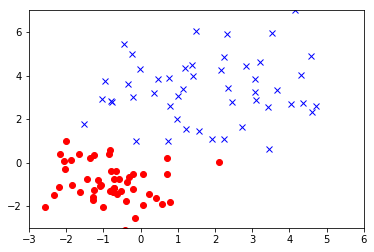

In [71]:
# simulated samples

mu1 = [-1, -1]
cov1 = np.eye(2)

mu2 = [2,3]
cov2 = np.eye(2) * 3

C1 = np.random.multivariate_normal(mu1, cov1, 50)
C2 = np.random.multivariate_normal(mu2, cov2, 50)

plt.plot(C1[:, 0], C1[:, 1], 'or')
plt.plot(C2[:, 0], C2[:, 1], 'xb')

plt.xlim([-3, 6])
plt.ylim([-3, 7])

In [68]:
Test = np.array([[1,2,3,4],[2,3,4,5]]).T*np.array([[1,2,3,4],[2,3,4,5]]).T[:,np.newaxis,:]*np.array([1,2])

In [72]:
from matplotlib.colors import BASE_COLORS
COLORS = list(BASE_COLORS.keys())[:-1]

# scatter plots for K classes
def kscatter_plot(X, classes):
    K = len(np.unique(classes))
    Cs = [X[classes == k] for k in range(K)]
    csm = [''.join([c,'.']) for c in COLORS]
    mum = [''.join([c,'x']) for c in COLORS[::-1]]

    for k in range(K):
        plt.plot(Cs[k][:,0], Cs[k][:, 1], csm[k])
        plt.plot(mus[k][0], mus[k][1], mum[k], markersize=10)

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
----means-------------
[[-0.87611123 -0.94328701]
 [ 1.82415074  3.21750475]]
----Class k: Cov-Mat----
[[ 0.66601998 -0.2097341 ]
 [-0.2097341   0.75240494]]
----Class k: Cov-Mat----
[[ 3.28487293  0.42654721]
 [ 0.42654721  2.46126009]]


Text(0,0.5,'log-likilihood')

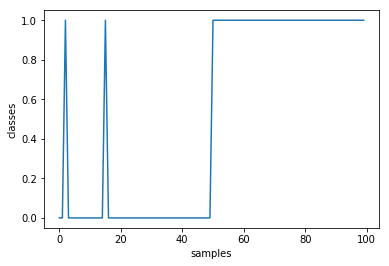

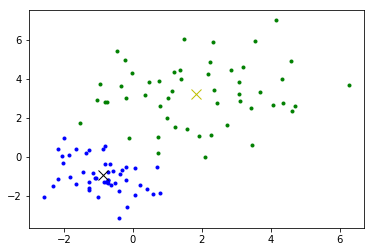

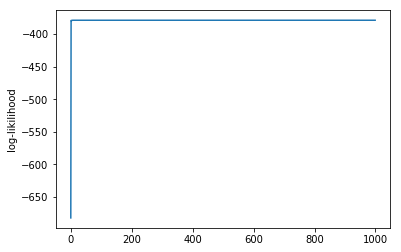

In [91]:
# applying gmm on this data
X = np.vstack((C1, C2))
K = 2

ks, mus, sigmas, pi, ll = GMM(X, 2, 1000)

classes = np.argmax(ks, axis=1)
print(classes)

print("----means-------------")
print(mus)
for k in range(K):
    print("----Class k: Cov-Mat----")
    print(sigmas[k])


plt.plot(classes)
plt.ylabel('classes')
plt.xlabel('samples')

plt.figure()
kscatter_plot(X, classes)
# Cs = [X[classes == k] for k in range(K)]
# csm = ['m.', 'c.']
# mum = ['rx', 'bx']

# for k in range(K):
#     plt.plot(Cs[k][:,0], Cs[k][:, 1], csm[k])
#     plt.plot(mus[k][0], mus[k][1], mum[k])

plt.figure()
plt.plot(ll)
plt.ylabel("log-likilihood")

## K-means vs GMM with data with different variances 

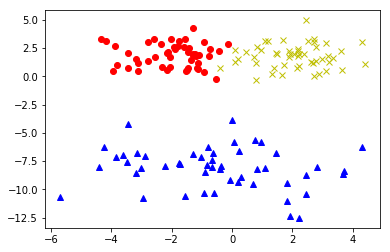

In [92]:
mu1 = [-2, 2]
cov1 = np.eye(2)

mu2 = [2,2]
cov2 = np.eye(2)

mu3 = [0,-8]
cov3 = np.eye(2) * 5

C1 = np.random.multivariate_normal(mu1, cov1, 50)
C2 = np.random.multivariate_normal(mu2, cov2, 50)
C3 = np.random.multivariate_normal(mu3, cov3, 50)

plt.plot(C1[:, 0], C1[:, 1], 'or')
plt.plot(C2[:, 0], C2[:, 1], 'xy')
plt.plot(C3[:, 0], C3[:, 1], '^b')

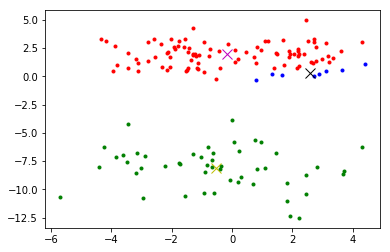

In [93]:
Xvs = np.vstack((C1, C2, C3))

mus, classes, errs = kmeans(Xvs, K=3)

kscatter_plot(Xvs, classes)

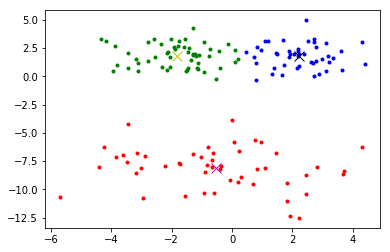

In [94]:
ks, mus, sigmas, pi, ll = GMM(Xvs, 3, 1000)

classes = np.argmax(ks, axis=1)

kscatter_plot(Xvs, classes)

## How to choose the initial centers for GMM? 

In [95]:
def GMM(X, K=2, maxiter=100, init=None):
    """ Gaussian Mixture Model
    
        Parameters
        ----------
        X         ndarray (N x D)
                  input data to cluster
        K         int
                  the number of clusters
        maxiter   int
                  the maximum number of iteration
        init      string
                  kmeans init or random
        
        Returns
        -------
        @kappa    ndarray (N x K)
                  responsibilities for each class
        @mus      ndarray (K x D)
                  centers for clusters
        @Sigmas   list of ndarray (D x D)
                  list of covariance matrices
        @pi       vector (K,)
                  mixing coefficient
        @LL       list
                  log-likelihood log
    """
    N, D = X.shape
    
    if init is None:
        # select initial centers - randomly for now, but YOU CAN USE K-MEANS for initial assignment
        cidx = np.random.choice(N, K, replace=False)
        mus = X[cidx, :]
        Sigmas = [np.eye(D) for k in range(K)]  # uni-variance
        pi = np.array([1/K] * K)
    else:
        # init with kmeans
        mus, classes, errs = kmeans(X, K=3)
        Nk = np.bincount(classes)
        pi = Nk / N
        mus = np.asarray(mus)
        Sigmas = [np.cov(X[classes==k].T) for k in range(K)]
    
    LL = []  # LogLikelihood log - expected to monotonically increasing
    
    # TODO: Finish GMM with your previous codes
    # repeat until convergence or up to maxiter
    for step in range(maxiter):
        # Expectation
        probs = mixnorm_dist(X, mus, Sigmas) 
        kappa = probs / np.sum(probs, axis=1, keepdims=True)
        classes = np.argmax(kappa, axis=1)
        
        # Maximization
        Nk = np.bincount(classes)
        for i in range(K):
            mus[i, :] = np.sum(X*kappa[:,i].reshape((-1,1)), axis=0)/Nk[i]             
            Sigmas[i][...] = np.sum((X-mus[i,:]).T*(X-mus[i,:]).T[:,np.newaxis,:]*kappa[:,i], axis=2)/Nk[i]
        pi = Nk[i]/np.sum(Nk) 
        
        ll = np.sum(np.log(np.sum(probs * pi, axis=1)))
        # convergence check: let us run w/o this for now.
        #if len(LL) > 0 and np.abs(ll - LL[-1]) < np.finfo(float).eps:
        #    break
        LL.append(ll)  # sum all the errors
            
    return kappa, mus, Sigmas, pi, LL

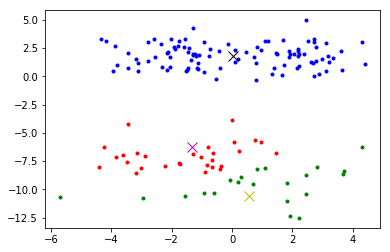

In [96]:
ks, mus, sigmas, pi, ll = GMM(Xvs, 3, 1000, init='kmeans')

classes = np.argmax(ks, axis=1)

kscatter_plot(Xvs, classes)

<hr/>
<hr/>
# Dimensionality Reduction

# Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is one of the dimensionality reduction tools. 
PCA is also used for feature extraction, data compression, and data visualization. 
It is also known as Karhunen-Loeve (KL) transform.

PCA reduces the dimension of the data by finding the data samples that vary the most. 
For this reason, we first look at the variance of the data. 

$$
var(\zv) = \frac{1}{N} \sum_{n=1}^{N} \zv_n^2 
$$

From the variance, PCA finds the orthogonal projection of the data onto the *principal subspace*, which is a lower dimensional linear space. 
Now, let us look for a direction $\vv$ that maximazes the variances.
Here, $\vv$ is a unit vector, so the dot product represents a projection onto it. 
The projection of data $\xv_n$ onto $\vv$ is 

$$
\zv = \xv_n^\top \vv.
$$

The variance of this projected data $\zv$ is 

$$
\begin{align*}
var(\zv) &= \frac{1}{N} \sum_{n=1}^{N} \vv^\top \xv_n \xv_n^\top \vv \\
         &= \vv^\top \Big( \frac{1}{N} \sum_{n=1}^{N} \xv_n \xv_n^\top \Big) \vv \\
         &= \vv^\top \Sigmav \vv
\end{align*}
$$

where $\Sigmav$ is a covariance matrix of $\xv_n$.

## Optimization Problem

$$
\begin{equation*}
\begin{aligned}
& \underset{\vv}{\text{maximize}}
& & \vv^\top \Sigmav \vv \\
& \text{subject to}
& & \vv^\top \vv = 1.
\end{aligned}
\end{equation*}$$

Using a Lagrange multiplier that is denoted by $\lambda$, we can make an unconstrained maximization of

$$
q(\vv) = \vv^\top \Sigmav \vv + \lambda ( 1 - \vv^\top \vv). 
$$

As usual, setting the derivative w.r.t. $\vv$, we can get

$$
0 = 2 \Sigmav \vv - 2 \lambda \vv, 
$$

$$
\lambda \vv = \Sigmav \vv.
$$

We can see that the direction vector $\vv$ is an eigenvector!

Also, since $\vv$ is a unit vector, we can apply $\vv^\top \vv = 1$ by left-multiplying $\vv^\top$,

$$
\lambda = \vv^\top \Sigmav \vv.
$$

So, we can obtain the maximum variance when $\vv$ is the eigenvector having the largest eigenvalue $\lambda$. 
This eigenvector is called as the *first principal component*. 

Other principal components, or other directions that are orthogonal to the first principal component, are found by the eigendecomposition of $\Sigmav$, or the singular value decomposition of data sample matrix $\Xm$ <u>**with zero means**</u>. 

$$
\Xm = \Um \Lambdav^{\frac{1}{2}} \Vm^\top,
$$

where the $\Lambdav$ is a diagonal matrix with eigenvalue elements. 


For implementation, we need to keep track of shapes of each matrix. 

- $\Xm$: N x D

- $\Um$: N x D

- $\Lambdav$: D x D

- $\Vm$: D x D


In [148]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [101]:
# PCA 

def pca(X):
    """ principal component analysis
    
        parameter
        ---------
        X        ndarray (N x D)
                 input data
                 
        return
        ------
        @U       ndarray (N x D)
                 left singular vectors
        @S       ndarray (D x D)
                 diagonal matrix with square root of eigenvalues
        @V       ndarray (D x D)
                 right singular vectors
        @mu      ndarray (D,)
                 1d vector of column means 
    """
    
    ### TODO: implement PCA using np.linalg.svd
    means=np.mean(X, axis=0)
    U, S, V = np.linalg.svd(X, full_matrices=False)
    
    return U, S, V.T, means

(-8, 8)

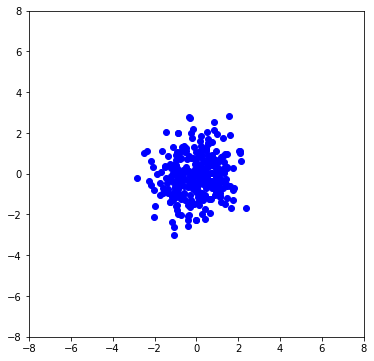

In [98]:
mu1 = np.array([0, 0])
S1 = np.eye(2)

X1 = np.random.multivariate_normal(mu1, S1, 300)

plt.figure(figsize=(6,6))
plt.plot(X1[:, 0], X1[:, 1], 'ob')
plt.xlim([-8, 8])
plt.ylim([-8, 8])

/Users/syc042813/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: covariance is not positive-semidefinite.
  after removing the cwd from sys.path.


(-8, 8)

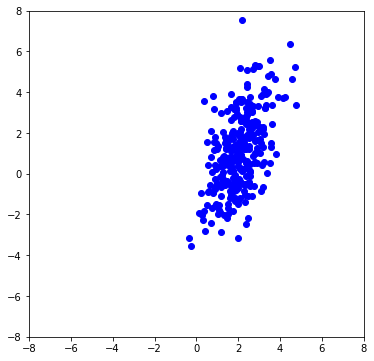

In [99]:
mu2 = np.array([2, 1])
S2 = np.array([[1,2],[0.5,3]])

X2 = np.random.multivariate_normal(mu2, S2, 300)

plt.figure(figsize=(6,6))
plt.plot(X2[:, 0], X2[:, 1], 'ob')
plt.xlim([-8, 8])
plt.ylim([-8, 8])

In [102]:
U, L, V, m1 = pca(X1)

In [103]:
L

array([ 18.868889 ,  16.2395782])

In [104]:
U

array([[ -1.72097421e-02,   8.15218460e-02],
       [ -1.00103749e-02,  -1.21721282e-01],
       [ -4.71328825e-02,   6.34606703e-02],
       [ -1.15787395e-02,   6.70504820e-02],
       [ -8.32870494e-02,  -1.23215705e-02],
       [ -1.20859106e-01,  -1.62176158e-02],
       [ -3.67563746e-02,   3.81702200e-02],
       [  4.07127099e-02,  -8.65826279e-04],
       [  2.65853997e-02,   7.97938205e-02],
       [ -4.84947466e-02,  -7.13541508e-02],
       [ -8.25876349e-02,   9.74714772e-02],
       [ -4.14684745e-02,   2.50217941e-02],
       [ -3.87773183e-02,   3.03471310e-02],
       [  1.92844681e-02,   1.14633292e-01],
       [  8.01543805e-02,  -1.01168868e-01],
       [  4.31829823e-02,  -2.08043034e-02],
       [ -2.94025028e-02,  -7.29442519e-02],
       [  1.88457361e-02,  -4.69406750e-02],
       [ -1.10316356e-03,  -2.85145524e-03],
       [ -4.85364614e-02,   1.23548202e-02],
       [ -1.17277534e-01,  -3.14883647e-03],
       [  1.24265727e-01,  -5.95243270e-02],
       [  

In [105]:
V

array([[-0.47438079,  0.88031975],
       [-0.88031975, -0.47438079]])

In [106]:
U.shape

(300, 2)

In [108]:
L

array([ 18.868889 ,  16.2395782])

In [109]:
V

array([[-0.47438079,  0.88031975],
       [-0.88031975, -0.47438079]])

In [110]:
COLORS = ['r', 'c', 'y']

def plot_pca(X, V, mu, L):
    plt.plot(X[:, 0], X[:, 1], 'ob')

    for d in range(V.shape[1]):
        l = np.sqrt(L[d])
        print(l)
        p1 = mu - l * V[:, d] 
        p2 = mu + l * V[:, d]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color=COLORS[d], linewidth=5)



4.34383344544
4.02983600168


array([ 18.868889 ,  16.2395782])

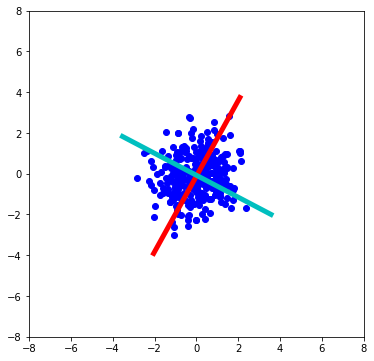

In [111]:
plt.figure(figsize=(6,6))
plot_pca(X1, V, m1, L)
plt.xlim([-8, 8])
plt.ylim([-8, 8])
L

In [112]:
U, L, V, m2 = pca(X2)

7.07036962562
4.7831044845


array([ 49.99012664,  22.87808851])

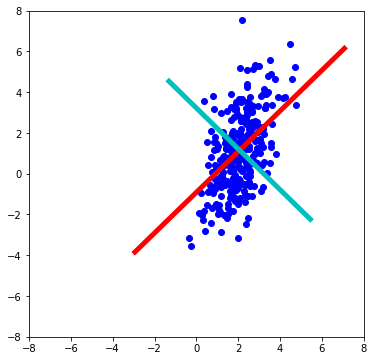

In [113]:
plt.figure(figsize=(6,6))
plot_pca(X2, V, m2, L)
plt.xlim([-8, 8])
plt.ylim([-8, 8])
L

In [114]:
V

array([[-0.70782345,  0.70638939],
       [-0.70638939, -0.70782345]])

(-10, 10)

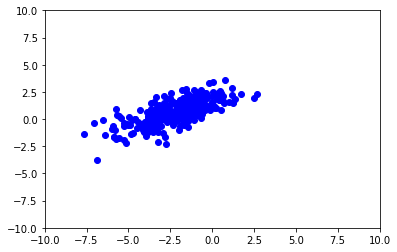

In [115]:
newX2 = (X2) @ V

plt.plot(newX2[:, 0], newX2[:, 1], 'ob')
plt.xlim([-10, 10])
plt.ylim([-10, 10])

# Review Standardization (Input Transformation)


(-10, 10)

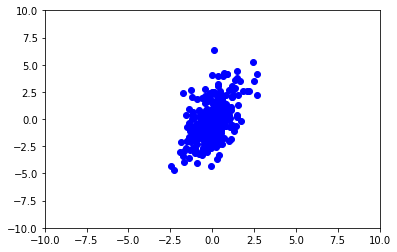

In [116]:
newX2 = (X2 - m2)

plt.plot(newX2[:, 0], newX2[:, 1], 'ob')
plt.xlim([-10, 10])
plt.ylim([-10, 10])

(-10, 10)

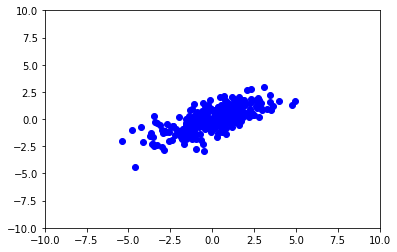

In [117]:
newX2 = (X2 - m2) @ V

plt.plot(newX2[:, 0], newX2[:, 1], 'ob')
plt.xlim([-10, 10])
plt.ylim([-10, 10])

(-10, 10)

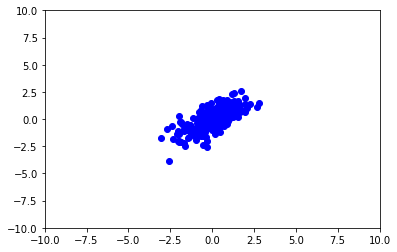

In [118]:
newX2 = (X2 - m2) @ V 
newX2 /= np.std(newX2, 0)

plt.plot(newX2[:, 0], newX2[:, 1], 'ob')
plt.xlim([-10, 10])
plt.ylim([-10, 10])

### Input Transformation 

<img src="http://webpages.uncc.edu/mlee173/teach/itcs6156/images/class/input_transform.png" width=600/>
<center>(Lecun, 1998)</center>